In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors as neigh

In [3]:
df = pd.read_csv('./data/12-3l-21_to_3-30-22.csv',skiprows=[x for x in range(1, 12)],)
df1 = pd.read_csv('./data/09-01-21_to_03-30-22.csv', skiprows=[x for x in range(1, 12)],)

frames = [df1, df] ##
df = pd.concat(frames) ##
df = df.iloc[:,[1, 2, 7]]
df = df[df.isin(['Low', 'High']) == False]
df = df[df.iloc[:,2].notna()]
dfM = df.reset_index(drop=True)
dfM = dfM.astype({dfM.columns[2]:'float64'})


#gluc.describe()

In [4]:
dfM[['MM-DD', 'HH:MM']] = dfM.iloc[:,0].str.split('T', 1, expand=True)
dfM.drop('Timestamp (YYYY-MM-DDThh:mm:ss)', axis=1, inplace=True)
dfM[['MM-DD', 'HH:MM']]

,MM-DD,HH:MM
0,2021-09-01,00:08:37
1,2021-09-01,00:13:37
2,2021-09-01,00:18:36
3,2021-09-01,00:23:37
4,2021-09-01,00:28:36
...,...,...
49773,2022-03-30,12:02:04
49774,2022-03-30,12:07:04
49775,2022-03-30,12:12:04
49776,2022-03-30,12:17:03


In [5]:
round_5 = lambda x: '0' + str(x - x % 5)
round_5(8)

'05'

In [6]:
dfM['HH:MM'] = dfM['HH:MM'].str.slice(start=0, stop=5)
dfM['MM-DD'] = dfM['MM-DD'].str.slice(start=5)
dfM['HH:MM'] = dfM['HH:MM'].apply(lambda x: x[0:3] + str(round_5(int(x[3:5]))[-2:])) 
#this is strictly unneccesarily complicated :shrugs:
#dfM['HH:MM'].unique()

In [7]:
means = dfM.groupby(['HH:MM'], as_index=False).mean().to_numpy().T
means[:,:10]

array([['00:00', '00:05', '00:10', '00:15', '00:20', '00:25', '00:30',
        '00:35', '00:40', '00:45'],
       [202.79651162790697, 201.316091954023, 201.04022988505747,
        201.6494252873563, 201.33142857142857, 201.16949152542372,
        198.9942196531792, 196.79768786127167, 195.51445086705203,
        196.8409090909091]], dtype=object)

In [8]:
days = dfM['MM-DD'].unique()
#len(days)
dates = np.zeros(len(dfM))
#daysarr = [0] * #len(dfM['MM-DD'].unique())
dayc = 0
for dat in dfM['MM-DD']:
    #print(dat)
    dates[dayc] = np.where(days==dat)[0][0]
    dayc+=1
    #np.where(days==dat)[0][0]
    #dates[dat] = np.where(days==dat)[0][0]

In [9]:
dates

array([  0.,   0.,   0., ..., 179., 179., 179.])

In [10]:
dfM['Day'] = dates
dfM

,Event Type,Glucose Value (mg/dL),MM-DD,HH:MM,Day
0,EGV,174.0,09-01,00:05,0.0
1,EGV,169.0,09-01,00:10,0.0
2,EGV,168.0,09-01,00:15,0.0
3,EGV,169.0,09-01,00:20,0.0
4,EGV,166.0,09-01,00:25,0.0
...,...,...,...,...,...
49773,EGV,141.0,03-30,12:00,179.0
49774,EGV,140.0,03-30,12:05,179.0
49775,EGV,138.0,03-30,12:10,179.0
49776,EGV,135.0,03-30,12:15,179.0


In [11]:
## GETTING HOW MANY DATA POINTS ARE IN EACH DAY
data_points_per_day = []
for x in range(len(days)):
    data_points_per_day.append(len(dfM.loc[dfM['Day'] == x]))
data_points_per_day = np.array(data_points_per_day)

In [12]:
## USING MOVING AVERAGES 
gluc = dfM.iloc[:,1]
fdsmooth = np.zeros(len(gluc))
#for x in range(6, len(gluc)-6):
#    fdsmooth[x] = (((0.5) * gluc[x-5]) + 
#                   (gluc[x-4]+gluc[x-3]+gluc[x-2]+gluc[x-1]+gluc[x]+gluc[x+1]+gluc[x+2]+gluc[x+3]+gluc[x+4])
#                   + ((0.5) * gluc[x+4])) / 10
for x in range(7, len(gluc)-7):
    fdsmooth[x] = (((0.5) * gluc[x-6]) + 
                   (gluc[x-5]+gluc[x-4]+gluc[x-3]+gluc[x-2]+gluc[x-1]+gluc[x]+gluc[x+1]+gluc[x+2]+gluc[x+3]+gluc[x+4]+gluc[x-5])
                   + ((0.5) * gluc[x+6])) / 12
smoothed = pd.concat([dfM, pd.DataFrame(fdsmooth, columns = ["smoothed"])], axis=1)

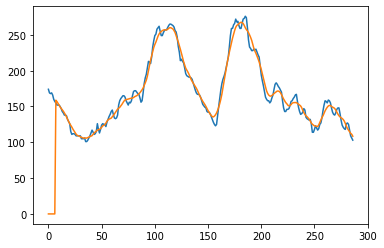

In [13]:
plt.plot(dfM['Glucose Value (mg/dL)'].loc[dfM['Day'] == 0])
plt.plot(smoothed['smoothed'].loc[dfM['Day'] == 0])
plt.show()

In [14]:
firstd = lambda x,h: sum(x*np.array([1,-8,8,-1]))/(12*h) 
secondd = lambda x,h: sum(x*np.array([-1,16,-30,16,-1]))/(12*(h**2))
#I'm not sure how to apply this for the last two and the first two endpoints - I'm going to assume that it makes sense 
#use a left centered/right-centered finite derivative for my boundaries. Need to check.
h = 5
gluc=smoothed.iloc[:,-1]
fda = np.zeros((len(gluc), 2))
for x in range(2, len(gluc)-2):
    fda[x] = firstd([*gluc[x-2:x], *gluc[x+1:x+3]],h), secondd(gluc[x-2:x+3],h)
smoothed = pd.concat([smoothed, pd.DataFrame(fda, columns = ["f_prime(x)", 'f_prime_prime(x)'])], axis=1)

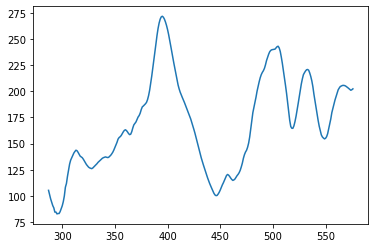

In [15]:
plt.plot(smoothed['smoothed'].loc[dfM['Day'] == 1])

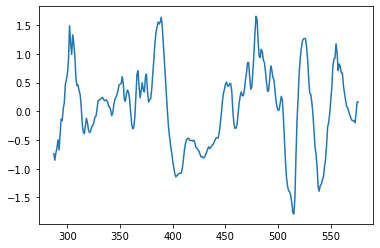

In [16]:
plt.plot(smoothed['f_prime(x)'].loc[dfM['Day'] == 1])

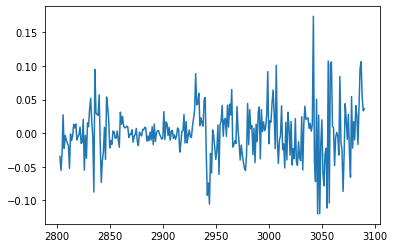

In [17]:
plt.plot(smoothed['f_prime_prime(x)'].loc[dfM['Day'] == 10])

In [18]:
day_points = smoothed.loc[smoothed['Day'] == 1]
fprime = day_points['f_prime(x)']
asdf = np.array(fprime > 0.7)
#print(asdf)
asf = []
for pt in range(len(asdf)):
    if asdf[pt] == True:
        asf.append(True)
        tmp = pt + 1
        while asdf[tmp] != False:
            asdf[tmp] = False
            tmp+=1
    else:
        asf.append(False)

In [19]:
## GETTING HOW MANY MEALS WERE EACH DAY
## 288 points in a day
meal_der_min = 0.7
pre_der_cutoff = 0.15
#post_der_cutoff = 0.0 ## real cutoff is return to pre BG
#deltaBG = 40
#Meal_bool = [False] * len(smoothed)
Meal_bool = []
for x in range(len(days)):
    day_points = smoothed.loc[smoothed['Day'] == x]
    fprime = day_points['f_prime(x)']
    fprime = np.array(fprime > meal_der_min)
    for pt in range(len(fprime)):
        if fprime[pt] == True:
            Meal_bool.append(True)
            tmp = pt + 1
            while tmp < len(fprime) and fprime[tmp] != False:
                fprime[tmp] = False
                tmp+=1
        else:
            Meal_bool.append(False)
smoothed['Meal_Event'] = Meal_bool

In [20]:
smoothed = smoothed.iloc[7:-7]
stdev = smoothed.iloc[5:-5 :, 6].std()

In [21]:
#lets split our data into 6 chunks. Increasing quickly, increasing rapidly, decreasing quickly, decreasing rapidly
#constant decreasing(within -0.5 stdev), constant increasing(within 0.5 stdev)
def split(v, s=stdev):
    if v > 2*s: #2stdevs on the right
        return 0
    elif v > s: #one stdev on the right
        return 1
    elif v > 0: #within one stdev on right
        return 2
    elif v > -s: #within one stdev on left.
        return 3
    elif v > -2*s: #1-2 stdev on left
        return 4
    else: #2 stdev on right
        return 5
#just added 1he here. Rewarding choosing the same label to a very very large level here(in terms of minimizing
#euclidean distance).
smoothed['tag'] = smoothed.iloc[:,6].apply(lambda x: split(x))

In [22]:
smoothed

,Event Type,Glucose Value (mg/dL),MM-DD,HH:MM,Day,smoothed,f_prime(x),f_prime_prime(x),Meal_Event,tag
7,EGV,155.0,09-01,00:40,0.0,158.750000,18.353472,-8.018750,False,0
8,EGV,152.0,09-01,00:45,0.0,156.958333,-3.101389,0.502778,False,5
9,EGV,152.0,09-01,00:50,0.0,154.458333,-0.538194,-0.008472,False,3
10,EGV,152.0,09-01,00:55,0.0,151.750000,-0.516667,0.015278,False,3
11,EGV,150.0,09-01,01:00,0.0,149.375000,-0.442361,0.012083,False,3
...,...,...,...,...,...,...,...,...,...,...
49766,EGV,134.0,03-30,11:25,179.0,126.125000,0.506250,-0.027083,False,2
49767,EGV,138.0,03-30,11:30,179.0,128.375000,0.440972,0.003194,False,2
49768,EGV,139.0,03-30,11:35,179.0,130.666667,0.480556,0.009722,False,2
49769,EGV,138.0,03-30,11:40,179.0,133.166667,2.800694,0.457639,True,0


In [23]:
def center(v):
    z = int(v[0:2])*60 + int(v[3:])
    x = 2 * np.pi * z / 1435 # 1435 -> 23:55
    cosx = np.cos(x)
    sinx = np.sin(x)
    return cosx, sinx

x= smoothed.loc[:,'HH:MM'].apply(lambda x: np.array(center(x)))
smoothed[['cosx', 'sinx']] = pd.DataFrame(x.to_list(),index=smoothed.index)

In [88]:
smoothed_mean, smoothed_stdev = smoothed.loc[:,'smoothed'].mean(), smoothed.loc[:,'smoothed'].std()
smoothed['bglNorm'] = smoothed.loc[:,'smoothed'].apply(lambda x: (x - mean) /stdev)

In [89]:
dfNumeric = smoothed.loc[:, ['bglNorm', 'tag', 'cosx', 'sinx']].to_numpy()
knn = neigh.NearestNeighbors(n_neighbors=3)
knn.fit(dfNumeric)

NearestNeighbors(n_neighbors=3)

In [95]:
dist,_= knn.kneighbors(X=[[-0.480948, 4, 0.965689, 0.259700]])

array([0.02207247, 0.04945257, 0.05094161])

In [91]:
smoothed.iloc[[45231, 40093, 40092]]

,Event Type,Glucose Value (mg/dL),MM-DD,HH:MM,Day,smoothed,f_prime(x),f_prime_prime(x),Meal_Event,tag,cosx,sinx,bglNorm
45238,EGV,168.0,03-14,01:05,163.0,158.583333,-0.797222,-0.032222,False,4,0.959773,0.280778,-0.483764
40100,EGV,151.0,02-24,00:55,145.0,156.125000,-0.992361,-0.064861,False,4,0.971143,0.238498,-0.525291
40099,EGV,155.0,02-24,00:50,145.0,160.291667,-0.824306,0.009583,False,4,0.976131,0.217182,-0.454906


In [92]:
normalized = lambda bgl, mean, stdev: (bgl-mean)/stdev

def sim_w_m(x):
    x = 1/(1+x)
    x = x/np.sum(x)
    return x    

In [192]:
def predicted_bgl(bgl,tag,hhmm,neighbors=3,mean=smoothed_mean,stdev=smoothed_stdev,nn=knn,df=smoothed):
    
    bglNorm = normalized(bgl, mean, stdev)
    cosx, sinx = center(hhmm)
    dist, ind = nn.kneighbors(X=[[bglNorm, tag, cosx, sinx]], n_neighbors=neighbors)
    
    rows = df.iloc[ind[0]]
    f_primes = rows.loc[:,['f_prime(x)']]
    simwmean_f_prime = np.sum(f_primes*sim_w_m(f_primes))
    
    return simwmean_f_prime*5 + bgl, f_primes, rows['Day'].unique, ind

In [134]:
predicted_bgl(158.583333, 4, '10:55')

f_prime(x)   -1.074778
dtype: float64


(f_prime(x)    153.209442
 dtype: float64,
        f_prime(x)
 36072   -1.034722
 25465   -1.276389
 25466   -1.129861,
 <bound method Series.unique of 36072    130.0
 25465     92.0
 25466     92.0
 Name: Day, dtype: float64>,
 array([[36065, 25458, 25459]]))

In [207]:
x,y = smoothed.iloc[1000:2000,[5,-4,3]].to_numpy(), dfNumeric[2000:]
model = neigh.NearestNeighbors(n_neighbors=3)
model.fit(y)

NearestNeighbors(n_neighbors=3)

In [208]:
pred = np.zeros(len(x))
for i,j in enumerate(x):
    pred[i],_,_,_ = predicted_bgl(j[0], j[1], j[2],neighbors=3)

In [217]:
np.sqrt(np.sum((smoothed.iloc[1001:2001:,5].to_numpy() - pred)**2)) #RMSE

95.91023720705606

In [156]:
pred

array([148.24025822, 152.51012529, 149.68581905, 147.54635245,
       145.34133156, 143.65434669, 141.61520649, 139.09560005,
       136.67786983, 132.71358907, 129.47315973, 126.49727249,
       123.92863808, 121.38737858, 119.38717271, 116.6492831 ,
       114.6411436 , 112.36305609, 109.81663241, 108.84354483,
       108.55657676, 107.55241249, 106.81113969, 105.83145982,
       105.42757146, 105.02992948, 106.83006183, 105.98030742,
       106.66749204, 107.50779288, 108.39734819, 108.64237319,
       109.41968486, 110.58434733, 112.43549205, 114.49332075,
       115.35364301, 116.63515644, 118.12494796, 118.72845322,
       119.41168643, 120.43172671, 122.55405981, 124.49314349,
       124.07391864, 125.44448384, 128.42734915, 130.97834077,
       132.55080727, 133.66797232, 134.28176216, 134.47836276,
       136.9092273 , 138.57540369, 140.93751129, 143.51213059,
       145.71554942, 147.6476836 , 148.32019131, 149.67729547,
       151.68087305, 153.48344389, 156.63849635, 158.53